# Описание проекта

От нас требуется построить модель машинного обучения, которая поможет определить регион, где бурить новую скважину с максимальной прибылью. Нам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Также требуется проанализировать возможную прибыль и риски техникой *Bootstrap.*

## Описание данных

Данные геологоразведки трёх регионов находятся в отдельных файлах, где каждая строка соответствует скважине со следующими характеристиками:

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

### Дополнительная информация:
- Для обучения модели подходит только линейная регрессия.
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбрать регион с наибольшей средней прибылью.

## Для выполнения поставленной задачи выполним следующие шаги:

1. Откроем файл с данными, изучим его, проведем предобработку и подготовку
2. Обучим и проверим модель для каждого региона:<br>
    2.1. Разобъем данные на обучающую и валидационную выборки в соотношении 75:25.<br>
    2.2. Обучим модель и сделаем предсказания на валидационной выборке.<br>
    2.3. Сохраним предсказания и правильные ответы на валидационной выборке.<br>
    2.4. Выведем на экран средний запас предсказанного сырья и RMSE модели.<br>
    2.5. Проанализируем результаты.
3. Подготовимся к расчёту прибыли:<br>
    3.1. Сохраним в отдельных переменных все ключевые значения для расчётов.<br>
    3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.<br>
    3.3. Напишем выводы по этапу подготовки расчёта прибыли.<br>
4. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:<br>
    4.1. Выберим скважины с максимальными значениями предсказаний.<br>
    4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.<br>
    4.3. Рассчитаем прибыль для полученного объёма сырья.<br>
5. Посчитаем риски и прибыль для каждого региона:<br>
    5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.<br>
    5.2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.<br>
    5.3. Напишем выводы и предложим регион для разработки скважин.
6. Напишем общий вывод.

# 1. Откроем файл с данными, изучим его, проведем предобработку и подготовку

Подключим необходимые библиотеки:

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.metrics import mean_squared_error

Данные по каждому региону загрузим в отдельную таблицу.

In [8]:
try:
    region1 = pd.read_csv('/Users/elenadolgova/Documents/Yandex praktikum/project8/geo_data_0.csv', 
                          index_col = 'id')
except:
    region1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', 
                          index_col = 'id')

In [9]:
try:
    region2 = pd.read_csv('/Users/elenadolgova/Documents/Yandex praktikum/project8/geo_data_1.csv', 
                          index_col = 'id')
except:
    region2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', 
                          index_col = 'id')

In [10]:
try:
    region3 = pd.read_csv('/Users/elenadolgova/Documents/Yandex praktikum/project8/geo_data_2.csv', 
                          index_col = 'id')
except:
    region3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', 
                          index_col = 'id')

Создадим список из названий трех таблиц, чтобы было удобно на него ссылаться в циклах.

In [11]:
regions = ['region1', 'region2', 'region3']

Взглянем на первые 5 строк первой таблицы, чтобы посмотреть какие именно данные в ней представлены.

In [12]:
region1.head()

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


## 1.1 Предобработка

Выведем общую информацию о таблицах и посмотрим какие типы данных размещены в них:

In [13]:
for reg in regions:
    print(reg)
    print(eval(reg).info())
    print()

region1
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None

region2
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None

region3
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0     

Пропущенных значений не содержится, а типы данных соответствуют их описанию. Проверим наличие дубликатов в каждой таблице.

In [14]:
for reg in regions:
    print(eval(reg).duplicated().sum())

0
0
0


### Вывод:

Пропущенных значений и дубликатов в таблицах не содержится, а типы данных соответствуют их описанию.

## 1.2 Масштабирование признаков

Выполним масштабирование количественных признаков методом стандартизации, для этого сначала соберем их в отдельный список (модель линейной регресии имеет параметр `normalize`, который осуществит это самостоятельно, но в целях обучения мы проделаем это в ручном режиме). Колонка `product` масштабироваться не будет, так как это целевой признак.

In [15]:
features = ['f0', 'f1', 'f2']

In [16]:
scaler = StandardScaler()

Выполним масштабирование для каждого региона (таблицы) и проверим успешное выполнение процесса - среднее по количественным показателям должно быть равно нулю.

In [17]:
for item in regions:
    reg = eval(item)
    scaler.fit(reg[features])
    reg[features] = scaler.transform(reg[features])
    print(item)
    print(round(reg.mean(),1))
    print()

region1
f0          0.0
f1         -0.0
f2          0.0
product    92.5
dtype: float64

region2
f0         -0.0
f1          0.0
f2          0.0
product    68.8
dtype: float64

region3
f0          0.0
f1         -0.0
f2         -0.0
product    95.0
dtype: float64



### Вывод:

Среднее по количественным признакам равно нулю - масштабирование выполнено.

# 2. Обучение и проверка модели

Обучим и проверим модель для каждого региона.<br>
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

Для каждого региона мы будем осуществлять следующую последовательность действий:

- разобъем данные на обучающую и валидационную выборки в соотношении 75:25
- обучим модель и сделаем предсказания на валидационной выборке
- сохраним предсказания и правильные ответы на валидационной выборке в списках `total_pred` и `total_target` (это мы проделаем для всех регионов подряд, а затем уже из этих списков выделим данные отдельно для региона)
- посчитаем и выведем на экране средний запас предсказанного сырья и RMSE модели

Выделим целевой признак в отдельный список.

In [18]:
target = ['product']

Объявим пустые списки предсказаний и правильных ответов на валидационной выборке:

In [19]:
total_pred = []

In [20]:
total_target = []

Выполним описанную последовательность действий для каждого региона в цикле.

In [21]:
print('Регион ','|Средний V запасов (тыс. баррелей)', '|RMSE (тыс. баррелей)')
for item in regions:
    reg = eval(item)
    features_train, features_valid, target_train, target_valid = (train_test_split(
        reg[features], reg[target], test_size = 0.25, random_state = 123))
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predictions)
    rmse = mse**0.5
    predictions_mean = predictions.mean()
    total_pred.append(predictions)
    total_target.append(target_valid.values)
    print(item, "|{:<33.2f}".format(predictions_mean), "|{:<34.2f}".format(rmse))

Регион  |Средний V запасов (тыс. баррелей) |RMSE (тыс. баррелей)
region1 |92.55                             |37.65                             
region2 |69.28                             |0.90                              
region3 |95.10                             |40.13                             


### Вывод:

Наилучшим образом модель линейной регрессии настроилась по региону 2, по остальным двум регионам ошибка значительно больше. Для каждого региона мы будем использовать соответствующую ему модель.

# 3. Подготовка к расчёту прибыли

## 3.1 Сохраним все ключевые значения для расчётов в отдельных переменных

Нам понадобятся:

Три вектора предсказания (по вектору на регион).<br>

Выделим из общего для всех регионов списка предсказаний `total_pred` соответствующие массивы для региона и приведем их данные к простому списку значений, понизив их изначальный уровень.

In [22]:
region1_pred = pd.Series(np.reshape(total_pred[0],-1))

In [23]:
region2_pred = pd.Series(np.reshape(total_pred[1], -1))

In [24]:
region3_pred = pd.Series(np.reshape(total_pred[2], -1))

Три вектора правильных ответов на валидационной выборке. Поступим аналогично векторам предсказаний.

In [25]:
region1_target = pd.Series(np.reshape(total_target[0], -1))

In [26]:
region2_target = pd.Series(np.reshape(total_target[1], -1))

In [27]:
region3_target = pd.Series(np.reshape(total_target[2], -1))

Бюджет на разработку скважин в регионе — 10 млрд рублей:

In [28]:
budget = 10*10**9

Количество лучших скважин - при разведке региона из 500 скважин выбирают 200 лучших для расчёта прибыли:

In [29]:
n = 200

Стоимость одного добытого барреля сырья на рынке - один баррель сырья приносит 450 рублей дохода:

In [30]:
barrel_price_rub = 450

Создадим списки названий предсказаний и правильных ответов для каждого из трех регионов.

In [31]:
regions_pred = ['region1_pred', 'region2_pred', 'region3_pred']

In [32]:
regions_target = ['region1_target', 'region2_target', 'region3_target']

## 3.2 Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним полученный объём сырья со средним запасом в каждом регионе.

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Безубыточность подразумевает равенство доходов и расходов. Значит общий доход по формуле:<br> (V баррелей) * (цена барреля в руб) * (кол-во скважин)<br> должен быть равен бюджету. Следовательно, (V баррелей) равен бюджету, деленному на стоимость барреля в руб.

In [33]:
V = round(budget/n/barrel_price_rub/1000,2)

Средний объём сырья для безубыточной разработки новой скважины составляет: (в тыс. баррелей)

In [34]:
V

111.11

Посчитаем среднее значение объема сырья в скважине в каждом регионе:

In [35]:
print('Регион ','|Средний V запасов (тыс. баррелей)')
for item in regions:
    reg = eval(item)
    print(item, "|{:<33.2f}".format(round(reg['product'].mean(),2)))

Регион  |Средний V запасов (тыс. баррелей)
region1 |92.50                            
region2 |68.83                            
region3 |95.00                            


### Выводы:

- мы сохранили все ключевые значения для расчётов в отдельных переменных
- мы расчитали достаточный объём сырья для безубыточной разработки новой скважины
- безубыточный объем превышает средние показатели по скважинам по регионам. Но эти все показатели являются средними - нам необходимо с использованием моделей тщательно подобрать самые производительные скважины для обеспечения прибыли.

# 4. Расчёт прибыли

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. Эта функция будет делать следующее:

- принимать на вход:
    - значение запасов по скважинам
    - предсказания запасов по скважинам
    - количество скважин для отбора
- выбирать скважины с максимальными значениями предсказаний
- суммировать целевое значение объёма сырья, соответствующее этим предсказаниям
- рассчитывать прибыль для полученного объёма сырья по формуле (V в тыс. баррелях) * (стоимость барреля в руб) - (бюджет)
- переводить расчитанный результат прибыли в млрд руб.

In [36]:
def income_mlrd(target, prediction, count):
    pred_sorted = prediction.sort_values(ascending=False)
    selected = target[pred_sorted.index][:count]
    return sum(selected)* 450 * 1000 * 10**-9 - 10

Проверим работу функции, посчитав максимальную потенциальную прибыль в каждом регионе:

In [37]:
for t, p in zip(regions_target, regions_pred):
    print(p, '-',"{:.2f} млрд руб.".format(income_mlrd(eval(t), eval(p), 200)))

region1_pred - 3.53 млрд руб.
region2_pred - 2.42 млрд руб.
region3_pred - 2.37 млрд руб.


### Вывод:

Мы написали функцию для расчета прибыли и проверили ее функциональность.

# 5. Посчитаем риски и прибыль для каждого региона

### 5.1 Применим технику Bootstrap с 1000 выборок и найдем распределение прибыли

Создадим случайный элемент, чтобы использовать его в выборках.

In [38]:
state = np.random.RandomState(123)

Создадим пустой список, куда будем складывать значение прибыли по выборкам по всем трем регионам. Затем отдельно разобъем этот список на три региона по индексу, кратному 1000.

In [39]:
total_income = []

Применять технику Bootstrap мы будем следующим образом.

Поскольку нам известно, что при разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли, то для каждого региона мы сделаем 1000 выборок по 500 точек с возвращением. Выбирать будем сначала из таблиц с предсказаниями модели, а затем по соответствующему индексу отберем точки из таблицы с целевыми значениями объёма запасов в скважине.

На основании этих двух выборок рассчитаем прибыль при помощи нашей функции `income_mlrd`, которая, в свою очередь, отберет 200 скважин на основе предсказаний и посчитает прибыль для региона.

Значение прибыли в каждой выборке мы сложим в наш список `total_income`.

In [40]:
%%time
for t, p in zip(regions_target, regions_pred):
    reg_t = eval(t)
    reg_p = eval(p)
    for i in range(1000):
        pred_subsample = reg_p.sample(n = 500, replace = True, random_state = state)
        target_subsample = reg_t[pred_subsample.index]
        total_income.append(income_mlrd(target_subsample, pred_subsample, 200))

CPU times: user 10.3 s, sys: 20.6 ms, total: 10.3 s
Wall time: 10.2 s


In [41]:
total_income = pd.Series(total_income)

Разобъем список `total_income` на регионы по индексу, кратному 1000, так как мы делали 1000 выборок в каждом регионе.

In [42]:
region1_income = total_income[:1000]

In [43]:
region2_income = total_income[1000:2000]

In [44]:
region3_income = total_income[2000:]

Для удобства работы с прибылью по регионам отдельно, запишем названия соответствующих таблиц в список.

In [45]:
regions_income = ['region1_income', 'region2_income', 'region3_income']

### 5.2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков

Для сравнения результатов по регионам заведем список, куда будем складывать результаты расчетов, чтобы затем сделать выводы на основании этой таблицы.

In [46]:
results = []

На основании данных по прибыли по каждому региону, полученных техникой Bootstrap мы проведем расчет следующих показателей:
- средняя прибыль по региону - расчитывается как среднее по 1000 значениям прибыли
- нижний предел 95% доверительного интервала для средней прибыли - расчитывается как 2.5% квантиль распределения прибыли (для 95% доверительного интервала для среднего значения необходимо отбросить крайние значения остатка от интервала - (100%-95%)/2 = 2.5%
- верхний предел 95% доверительного интервала для средней прибыли - расчитывается как 97.5% квантиль распределения прибыли
- вероятность убытков в регионе - расчитывается как доля числа отрицательных значений прибыли в распределении

Все показатели соберем в таблицу `results` и построим диаграммы распределения прибыли для каждого региона, чтобы убедиться в том, что показатели посчитаны корректно.

AxesSubplot(0.125,0.125;0.775x0.755)


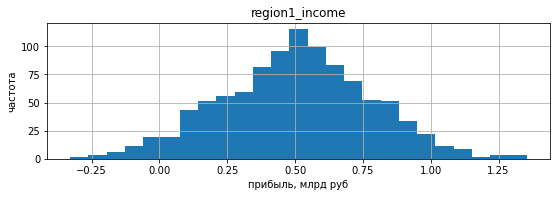

AxesSubplot(0.125,0.125;0.775x0.755)


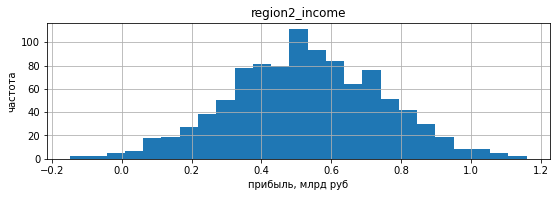

AxesSubplot(0.125,0.125;0.775x0.755)


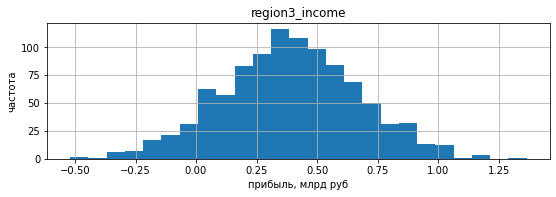

In [47]:
for item in regions_income:
    reg = eval(item)
    lower = reg.quantile(0.025)
    high = reg.quantile(0.975)
    loss_prob = sum(reg<0)/len(reg)
    plt.show()
    plt.title(item)
    plt.xlabel('прибыль, млрд руб')
    plt.ylabel('частота')
    print(reg.hist(bins = 25, figsize = (9,2.5)))
    results.append([reg.mean(), lower, high, loss_prob])

Соберем список результатов табличный вид при помощи `DataFrame`.

In [48]:
results_df = (pd.DataFrame(data = results, 
            index = ['прибыль-регион 1 (млрд руб.)', 
                     'прибыль-регион 2 (млрд руб.)', 
                     'прибыль-регион 3 (млрд руб.)'], 
            columns = ['cреднее', 'низ 95% дов.инт', 'верх 95% дов.инт','вер-ть убытков']))

Отформатируем значения в колонках:

In [49]:
for col in results_df.columns[:3]:
    results_df[col] = results_df[col].map('{:.2f}'.format)

In [50]:
results_df['вер-ть убытков'] = results_df['вер-ть убытков'].map('{:.1%}'.format)

In [51]:
results_df

,cреднее,низ 95% дов.инт,верх 95% дов.инт,вер-ть убытков
прибыль-регион 1 (млрд руб.),0.50,-0.05,1.03,4.0%
прибыль-регион 2 (млрд руб.),0.53,0.10,0.95,0.9%
прибыль-регион 3 (млрд руб.),0.39,-0.17,0.93,7.7%


### Выводы:

Построенные гистограммы соответствуют значениям, представленным в таблице.

Как видно из таблицы, наибольшее среднее значение прибыли достигается в `регионе 2`. В нем же весь доверительный интервал находится в положительной зоне прибыли, то есть не содержит убытков, что подтверждается и показателем вероятности убытков - он также самый низкий у `региона 2`.

Нам необходимо оставить лишь те регионы, в которых вероятность убытков меньше 2.5% и среди них выбирать регион с наибольшей средней прибылью. Но глядя на такие результаты, можно сказать, что `регион 2` является абсолютным лидером по всем показателям среди трех регионов, а значит регионом, где добыча принесёт наибольшую прибыль следует выбрать `регион 2`.

## 6. Общий вывод

### В ходе работы мы проделали следующие шаги:

1. Открыли файл с данными, изучили его, провели предобработку и подготовку
2. Обучили и проверили модель для каждого региона<br>
3. Подготовились к расчёту прибыли<br>
4. Написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели<br>
5. Посчитали риски и прибыль для каждого региона<br>

### На основе проделанной работы сделали выводы:

- наилучшим образом модель линейной регрессии настроилась по региону 2, по остальным двум регионам ошибка значительно больше.
- безубыточный объем превышает средние показатели по скважинам по регионам. Но эти показатели являются средними и при тщательном подборе самых производительных скважин можно обеспечить прибыль.
- наибольшее среднее значение прибыли достигается в `регионе 2`. В нем же весь доверительный интервал находится в положительной зоне прибыли, то есть не содержит убытков, что подтверждается и показателем вероятности убытков - он также самый низкий.
- `регион 2` является абсолютным лидером по всем показателям среди трех регионов, а значит регионом, где добыча принесёт наибольшую прибыль следует выбрать `регион 2`.